In [1]:
import torch.multiprocessing as mp
mp.set_start_method('spawn', force=True)

# Предсказание цены автомобиля при помощи нейронной сети

**В этом ноутбуке мы последовательно:**
- Установим и импортируем нужные библиотеки
- Очистим данные и добавим новые информативные признаки
- Подготовим выборки, закодируем и масштабируем признаки
- Построим нейросетевую модель

---

## 1. Установка и импорт

In [4]:
import pandas as pd, numpy as np, math, joblib, gc, warnings, os, random, json, pickle, time
import torch, torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from tqdm.notebook import tqdm, trange
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

# Импортируем библиотеки, фиксируем сиды и выбираем устройство.
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tqdm.pandas()


 ## 2. Загрузка данных

In [3]:
CARS_FILE_ID = '1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI'
RANDOM_STATE = 42

random.seed(RANDOM_STATE)
np.random.seed(RANDOM_STATE)

!gdown --id {CARS_FILE_ID}

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI
From (redirected): https://drive.google.com/uc?id=1liFEe1-yFISPSpRSvbv1wIH_avYNGmBI&confirm=t&uuid=ef7d9071-48c0-4452-97bf-0e700061bde3
To: /kaggle/working/dataset.csv
100%|██████████████████████████████████████| 1.01G/1.01G [00:12<00:00, 82.4MB/s]


In [4]:
def mem_usage(df):
    return f"{df.memory_usage(deep=True).sum()/1024**2:.1f} MB"


df = pd.read_csv("dataset.csv", low_memory=False)
print(f"RAW shape        : {df.shape}, mem: {mem_usage(df)}")

print("\nHead:")
display(df.head())


RAW shape        : (604047, 24), mem: 1458.8 MB

Head:


,production_year,mileage,condition,owners_number,pts_original,horse_power,accidents_resolution,region,seller_type,brand,...,engine_displacement,engine_power,fuel_rate,steering_wheel,price,price_segment,tags,auto_class,equipment,complectation_available_options
0,2020,31000,CONDITION_OK,0,NaN,170.0,OK,Оренбург,COMMERCIAL,Abarth,...,1368.0,170.0,6.6,LEFT,1900000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,S,sport-suspension;seats-2,NaN
1,2017,96000,CONDITION_OK,0,NaN,170.0,OK,Оренбург,COMMERCIAL,Abarth,...,1368.0,170.0,6.4,LEFT,2300000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,S,seats-2,NaN
2,2019,42500,CONDITION_OK,1,True,179.0,OK,Санкт-Петербург,PRIVATE,Abarth,...,1368.0,180.0,5.8,LEFT,2895000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,A,seats-4,NaN
3,2013,130000,CONDITION_OK,2,True,160.0,OK,Москва,PRIVATE,Abarth,...,1368.0,160.0,5.4,LEFT,1750000,MEDIUM,allowed_for_credit;auction_call_free_report;av...,A,automatic-lighting-control;voice-recognition;l...,NaN
4,2009,47800,CONDITION_OK,4,True,135.0,OK,Москва,PRIVATE,Abarth,...,1368.0,135.0,6.5,LEFT,2000000,MEDIUM,allowed_for_credit;auction_call_free_report;au...,A,leather-gear-stick;seats-4;apple-carplay;usb;a...,NaN


## 3. Предобработка и признаки

In [5]:
# АНОМАЛИЯ
df.drop(210905, inplace=True)

df["fuel_rate"].fillna(df["fuel_rate"].median(), inplace=True)
df["pts_original"].fillna(True, inplace=True)
df["accidents_resolution"].fillna("OK", inplace=True)
df["auto_class"].fillna("NOT SPECIFIED", inplace=True)
df.drop("horse_power", axis=1, inplace=True)


def optimize_types(d):
    for col in d.select_dtypes(include=["int64"]).columns:
        d[col] = pd.to_numeric(d[col], downcast="integer")
    for col in d.select_dtypes(include=["float64"]).columns:
        d[col] = pd.to_numeric(d[col], downcast="float")
    return d


df = optimize_types(df)
print(f"After dtype optimisation mem: {mem_usage(df)}")


After dtype optimisation mem: 1420.9 MB


In [6]:
def split_max(x):
    try:
        return max(map(int, x.split(';')))
    except:
        return np.nan

df['seats_numeric'] = df['seats'].progress_apply(split_max)
df.drop('seats', axis=1, inplace=True)

  0%|          | 0/604046 [00:00<?, ?it/s]

### Преобразование мульти­категорий в дамми-признаки  
В этой ячейке мы:  
- Собираем все уникальные значения из колонок с «;»  
- Создаём бинарные столбцы для каждого уникального тега/опции/оборудования  
- Считаем, сколько элементов было в каждой строке

In [7]:
def get_uniques(series):
    u = set()
    for v in series.dropna():
        for w in v.split(";"):
            w = w.strip()
            if w:
                u.add(w)
    return list(u)


multi_cols = ["tags", "complectation_available_options", "equipment"]
uniques = {c: get_uniques(df[c]) for c in multi_cols}


def make_dummies(df, col, uniq):
    out = (
        df[col]
        .str.get_dummies(sep=";")
        .reindex(columns=uniq, fill_value=0)
        .astype("int8")
    )
    out.columns = [f"{col}__{c}" for c in uniq]
    df[f"{col}_cnt"] = df[col].progress_apply(
        lambda x: len(str(x).split(";")) if pd.notna(x) else 0
    )
    return out


tags_d = make_dummies(df, "tags", uniques["tags"])
opts_d = make_dummies(
    df,
    "complectation_available_options",
    uniques["complectation_available_options"],
).drop(columns=["complectation_available_options__condition"], errors="ignore")
eq_d = make_dummies(df, "equipment", uniques["equipment"]).drop(
    columns=["equipment__condition"], errors="ignore"
)

full = pd.concat([df.drop(multi_cols, axis=1), tags_d, opts_d, eq_d], axis=1)
del tags_d, opts_d, eq_d
gc.collect()
print("Dummies created, shape:", full.shape, "mem:", mem_usage(full))


  0%|          | 0/604046 [00:00<?, ?it/s]

  0%|          | 0/604046 [00:00<?, ?it/s]

  0%|          | 0/604046 [00:00<?, ?it/s]

Dummies created, shape: (604046, 590) mem: 753.8 MB


### Отбраковка сильно коррелирующих признаков
Здесь мы:

- Вычисляем корреляцию всех числовых признаков между собой

- Удаляем одну из пары признаков с корреляцией > 0.8

- Сохраняем важные столбцы (цену, год выпуска и счётчики мульти-категорий)

In [8]:
num = full.select_dtypes(include=["number"]).drop(
    columns=["price"], errors="ignore"
)

corr = num.corr().abs()
mask = np.triu(np.ones(corr.shape), 1).astype(bool)
upper = corr.where(mask)
mean_corr = corr.mean()

drop = set()
for i, j in zip(*np.where(upper > 0.80)):
    a, b = corr.index[i], corr.columns[j]
    drop.add(a if mean_corr[a] > mean_corr[b] else b)

# защищаем важные признаки от удаления
essential_cols = {
    "price",
    "production_year",  # уже были
    "tags_cnt",
    "equipment_cnt",
    "complectation_available_options_cnt",  # NEW
}
drop -= essential_cols

f = full.drop(columns=drop, errors="ignore").copy()
print("After corr-pruning shape:", f.shape)


After corr-pruning shape: (604046, 426)


### Создание новых признаков  
В этой ячейке мы:
- Добавляем полиномиальные признаки (год²), логарифмические трансформации и отношения (пробег в год, мощность на литр и т.п.)
- Рассчитываем возраст автомобиля и на его основе новые фичи: `age_x_power`, `power_per_year` и пр.
- Вводим булевы индикаторы: один владелец, новый автомобиль, «очень старый»
- Бинируем возраст и пробег в категории с помощью `pd.cut` и `pd.qcut`
- Удаляем исходные столбцы `production_year` и `engine_displacement`

In [9]:
# НОВЫЕ ПРИЗНАКИ
f["production_year_sq"] = f["production_year"] ** 2
f["age"] = 2025 - f["production_year"]
f["mileage_per_year"] = f["mileage"] / f["age"].clip(1)
f["log_mileage"] = np.log1p(f["mileage"])
f["power_per_liter"] = f["engine_power"] / f["engine_displacement"].clip(0.1)
f["age_x_power"] = f["age"] * f["engine_power"]
f["age_x_mileage"] = f["age"] * f["mileage"]
f["log_disp"] = np.log1p(f["engine_displacement"])
f["disp_per_door"] = f["engine_displacement"] / f["doors_count"].clip(1)
f["is_one_owner"] = (f["owners_number"] == 1).astype(int)
f["is_new"] = ((f["mileage"] < 1000) & (f["owners_number"] <= 1)).astype(int)
f["is_very_old"] = (f["age"] > 20).astype(int)
f["power_per_year"] = f["engine_power"] / (f["age"] + 1)
f["age_x_mileage"] = f["age"] * f["mileage"]  # уже был – перезаписываем, ок

f["age_bucket"] = pd.cut(
    f["age"], bins=[-1, 0, 3, 7, 12, 20, 35, 100, np.inf], labels=False
)
f["mileage_bucket"] = pd.qcut(
    f["mileage"], q=10, duplicates="drop", labels=False
)

# Убираем теперь ненужные столбцы
f.drop(["production_year", "engine_displacement"], axis=1, inplace=True)
print("Final feature DF shape:", f.shape)


Final feature DF shape: (604046, 439)


### Разбиение и подготовка данных  
- Делим на train/test (15%) и сбрасываем индексы  
- Применяем `log1p` к цене  
- Строим сглаженную среднюю цену по бренду и мержим её в оба датасета

In [10]:
train_df, test_df = train_test_split(f, test_size=0.15, random_state=SEED)
train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

train_df["price_log"] = np.log1p(train_df["price"])
test_df["price_log"] = np.log1p(test_df["price"])

global_mean = train_df["price"].mean()
α = 10  # коэффициент сглаживания

smoothing_stats = (
    train_df.groupby("brand")["price"]
    .agg(["count", "mean"])
    .rename(columns={"count": "brand_count", "mean": "brand_mean"})
)

smoothing_stats["brand_price_smooth"] = (
    smoothing_stats["brand_mean"] * smoothing_stats["brand_count"]
    + global_mean * α
) / (smoothing_stats["brand_count"] + α)

# мёржим сглаженные значения
train_df = train_df.merge(
    smoothing_stats[["brand_price_smooth"]], on="brand", how="left"
)

test_df = test_df.merge(
    smoothing_stats["brand_price_smooth"], on="brand", how="left"
)

test_df["brand_price_smooth"].fillna(global_mean, inplace=True)


### OOF Target- и Frequency-Encoding категорий  
- Для каждого категориального признака из `cat_cols` выполняем KFold-оценку:  
  - Строим out-of-fold target-encoding на основе средней цены.  
  - Сохраняем карту средних для теста.  
- Одновременно считаем frequency-encoding (долю каждого значения) и добавляем в train/test.

In [11]:
cat_cols = [
    "condition",
    "accidents_resolution",
    "region",
    "seller_type",
    "brand",
    "model",
    "body_type",
    "steering_wheel",
    "price_segment",
    "auto_class",
]

te_maps = {}
freq_cols = []
kf = KFold(n_splits=5, shuffle=True, random_state=SEED)
global_mean = train_df["price"].mean()

for col in tqdm(cat_cols, desc="Target/Freq enc"):
    # OOF-target-encoding
    oof = pd.Series(index=train_df.index, dtype=float)
    for tr_idx, vl_idx in kf.split(train_df):
        means = train_df.iloc[tr_idx].groupby(col)["price"].mean()
        oof.iloc[vl_idx] = (
            train_df.iloc[vl_idx][col].map(means).fillna(global_mean)
        )
    train_df[col + "_te"] = oof
    te_map = train_df.groupby(col)["price"].mean()
    te_maps[col] = te_map
    test_df[col + "_te"] = test_df[col].map(te_map).fillna(global_mean)

    # freq-encoding
    freq = train_df[col].value_counts(normalize=True)
    train_df[col + "_fe"] = train_df[col].map(freq)
    test_df[col + "_fe"] = test_df[col].map(freq).fillna(0)
    freq_cols.append(col + "_fe")


Target/Freq enc:   0%|          | 0/10 [00:00<?, ?it/s]

### Масштабирование числовых признаков

подготавливаем числовые признаки к обучению модели:

- Собираем список всех числовых колонок: оригинальные (`num_cols`), таргет-энкодинги (`te_cols`) и частотные признаки (`freq_cols`).
- Удаляем из списка отсутствующие колонки (на случай, если они были отброшены ранее)
- Заполняем пропущенные значения нулями
- Применяем `StandardScaler` для нормализации всех признаков.

In [13]:
num_cols = [
    "mileage",
    "owners_number",
    "doors_count",
    "engine_power",
    "fuel_rate",
    "production_year_sq",
    "age",
    "mileage_per_year",
    "log_mileage",
    "power_per_liter",
    "age_x_power",
    "age_x_mileage",
    "log_disp",
    "disp_per_door",
    "is_one_owner",
    "is_new",
    "is_very_old",
    "power_per_year",
    "seats_numeric",
    "brand_price_smooth",
    "age_bucket",
    "mileage_bucket",
    "tags_cnt",
    "equipment_cnt",
    "complectation_available_options_cnt",
]

te_cols = [c + "_te" for c in cat_cols]
all_num = num_cols + freq_cols + te_cols

# убираем колонки, которых в DataFrame реально нет
all_num = [c for c in all_num if c in train_df.columns]

# заполняем возможные NaN, чтобы StandardScaler не упал
train_df[all_num] = train_df[all_num].fillna(0)
test_df[all_num] = test_df[all_num].fillna(0)

scaler = StandardScaler().fit(train_df[all_num])
joblib.dump(scaler, "scaler.pkl")

train_df[all_num] = scaler.transform(train_df[all_num])
test_df[all_num] = scaler.transform(test_df[all_num])


### Подготовка Dataset и DataLoader

In [14]:
class CarDataset(Dataset):
    def __init__(self, df, use_log=False):
        target = "price_log" if use_log else "price"
        self.y = torch.tensor(df[target].values, dtype=torch.float32)
        self.num = torch.tensor(df[all_num].values, dtype=torch.float32)
        self.cat = torch.tensor(df[label_code_cols].values, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.num[idx], self.cat[idx], self.y[idx]


batch = 256
train_loader = DataLoader(
    CarDataset(train_df), batch_size=batch, shuffle=True, num_workers=0
)
val_loader = DataLoader(
    CarDataset(test_df), batch_size=batch, shuffle=False, num_workers=0
)


## 5. Модель и обучение

### Обзор архитектуры

В этой ячейке реализована модель по аналогии TabNet для задачи регрессии на табличных данных. Основные компоненты:

1. **FeatureBlock**  
   - Линейное преобразование входа → `output_dim` (или `2×` при включённом GLU)  
   - LayerNorm + Dropout  
   - Опциональный GLU‑гейт: делит выход на две части и умножает «фичи» на сигмоиду «ворот»

2. **Sparsemax**  
   - Жёсткий аналог softmax  
   - Выдаёт разреженные веса суммы 1, обнуляя маловажные элементы

3. **AttentiveTransformer**  
   - Преобразует скрытое представление `x_trans` (размер `feature_dim`) в «маску внимания» по исходным признакам (`input_dim`)  
   - Учитывает «prior» (остаточную важность), чтобы последующие шаги смотрели на новые признаки

4. **FeatureTransformer**  
   - Состоит из:
     1. **Первого блока**: `input_dim → feature_dim`  
     2. **Shared‑блоков** (GLU + residual) внутри `feature_dim`  
     3. **Step‑блоков** (GLU + residual) внутри `feature_dim`
   - Дает гибкое нелинейное представление отобранных признаков

5. **TabNetRegressor**  
   - Первичная трансформация всего `x` через `FeatureTransformer`  
   - Цикл из `n_steps`:
     1. `AttentiveTransformer` → маска внимания  
     2. Обновление `prior = prior * (relaxation - mask)`  
     3. Поэлементное умножение `x_masked = mask * x`  
     4. Обработка `x_masked` через `FeatureTransformer` → `x_step`  
     5. Суммирование в аккумулятор `total_o += x_step`  
   - В конце простой линейный регрессор `nn.Linear(feature_dim, output_dim)`

In [15]:
import math
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import OneCycleLR


class FeatureBlock(nn.Module):
    def __init__(self, input_dim, output_dim, apply_glu=True, dropout=0.2):
        super().__init__()
        self.apply_glu = apply_glu
        fc_out = output_dim * (2 if apply_glu else 1)
        self.fc = nn.Linear(input_dim, fc_out, bias=False)
        self.norm = nn.LayerNorm(fc_out, eps=1e-6)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.fc(x)
        x = self.norm(x)
        if self.apply_glu:
            out, gate = x.chunk(2, dim=1)
            x = out * torch.sigmoid(gate)
        return self.dropout(x)


# Sparsemax для attention
class Sparsemax(nn.Module):
    def __init__(self, dim=1):
        super().__init__()
        self.dim = dim

    def forward(self, inp):
        sorted_, _ = torch.sort(inp, descending=True, dim=self.dim)
        cumsum_ = torch.cumsum(sorted_, dim=self.dim)
        k_range = torch.arange(
            1, inp.size(self.dim) + 1, device=inp.device, dtype=inp.dtype
        )
        k_range = k_range.view([1] * (inp.dim() - 1) + [-1])
        support = sorted_ - (cumsum_ - 1) / k_range > 0
        k = support.sum(dim=self.dim, keepdim=True)
        tau_sum = torch.gather(cumsum_, self.dim, k - 1).squeeze(self.dim)
        tau = (tau_sum - 1) / k.squeeze(self.dim)
        return torch.clamp(inp - tau.unsqueeze(self.dim), min=0)


class AttentiveTransformer(nn.Module):
    def __init__(self, feature_dim, input_dim, dropout=0.2):
        super().__init__()
        self.block = FeatureBlock(
            feature_dim, input_dim, apply_glu=False, dropout=dropout
        )
        self.sparsemax = Sparsemax(dim=1)

    def forward(self, x_transformed, prior):
        x = self.block(x_transformed)
        x = x * prior
        return self.sparsemax(x)


class FeatureTransformer(nn.Module):
    def __init__(self, input_dim, feature_dim, n_shared=3, n_total=6, dropout=0.2):
        super().__init__()
        self.first = FeatureBlock(input_dim, feature_dim, apply_glu=True, dropout=dropout)
        self.shared_blocks = nn.ModuleList(
            [
                FeatureBlock(feature_dim, feature_dim, apply_glu=True, dropout=dropout)
                for _ in range(n_shared - 1)
            ]
        )
        self.step_blocks = nn.ModuleList(
            [
                FeatureBlock(feature_dim, feature_dim, apply_glu=True, dropout=dropout)
                for _ in range(n_total - n_shared)
            ]
        )

    def forward(self, x):
        # первый блок без residual
        out = self.first(x)
        # с residual
        for blk in self.shared_blocks:
            y = blk(out)
            out = y + out * math.sqrt(0.5)
        # с residual
        for blk in self.step_blocks:
            y = blk(out)
            out = y + out * math.sqrt(0.5)
        return out


class TabNetRegressor(nn.Module):
    def __init__(
        self,
        input_dim,
        feature_dim=128,
        output_dim=1,
        n_steps=4,
        n_shared=3,
        relaxation=1.3,
        dropout=0.2,
    ):
        super().__init__()
        self.feature_dim = feature_dim
        self.n_steps = n_steps
        self.relaxation = relaxation

        self.initial_transform = FeatureTransformer(
            input_dim=input_dim,
            feature_dim=feature_dim,
            n_shared=n_shared,
            n_total=2 * n_shared,
            dropout=dropout,
        )

        self.attentive_transformers = nn.ModuleList()
        self.feature_transformers = nn.ModuleList()
        for _ in range(n_steps):
            self.attentive_transformers.append(
                AttentiveTransformer(feature_dim, input_dim, dropout=dropout)
            )
            self.feature_transformers.append(
                FeatureTransformer(
                    input_dim=input_dim,
                    feature_dim=feature_dim,
                    n_shared=n_shared,
                    n_total=4,
                    dropout=dropout,
                )
            )

        self.regressor = nn.Linear(feature_dim, output_dim)

    def forward(self, x):
        B, D = x.size()
        # Первичное преобразование
        x_trans = self.initial_transform(x)  # (B, feature_dim)
        total_o = torch.zeros(B, self.feature_dim, device=x.device)
        prior = torch.ones(B, D, device=x.device)

        for i in range(self.n_steps):
            mask = self.attentive_transformers[i](x_trans, prior)
            prior = prior * (self.relaxation - mask)
            x_masked = mask * x
            x_step = self.feature_transformers[i](x_masked)
            total_o += x_step

        return self.regressor(total_o).squeeze(1)
        

### Настройка обучения  



In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = TabNetRegressor(input_dim=len(all_num)).to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)

EPOCHS = 300
steps_per_epoch = len(train_loader)

sched = OneCycleLR(
    optimizer=opt,
    max_lr=1e-2,
    steps_per_epoch=steps_per_epoch,
    epochs=EPOCHS,
    pct_start=0.3,
    div_factor=10,
    final_div_factor=1000,
)

criterion = nn.SmoothL1Loss()

### Цикл обучения и валидации

In [17]:
# Training loop
for epoch in trange(1, EPOCHS + 1, desc="Epochs"):
    # ===== TRAIN =====
    model.train()
    train_losses = []
    for xn, _, y_price in train_loader:
        xn = xn.to(device)
        y_price = y_price.to(device)

        opt.zero_grad()
        preds = model(xn)
        loss = criterion(preds, y_price)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        opt.step()
        sched.step()  # step per batch

        train_losses.append(loss.item())

    mean_train_loss = sum(train_losses) / len(train_losses)

    # ===== VALIDATION =====
    model.eval()
    val_losses, all_preds, all_trues = [], [], []
    with torch.no_grad():
        for xn, _, y_price in val_loader:
            xn = xn.to(device)
            y_price = y_price.to(device)

            preds = model(xn)
            loss = criterion(preds, y_price)

            val_losses.append(loss.item())
            all_preds.append(preds.cpu())
            all_trues.append(y_price.cpu())

    mean_val_loss = sum(val_losses) / len(val_losses)
    preds = torch.cat(all_preds).numpy()
    trues = torch.cat(all_trues).numpy()

    rmse = mean_squared_error(trues, preds, squared=False)
    r2 = r2_score(trues, preds)

    # ===== PRINT =====
    if epoch % 5 == 0:
        print(
            f"Epoch {epoch:3d} | Train Loss: {mean_train_loss:.4f} | "
            f"Val Loss: {mean_val_loss:.4f} | RMSE: {rmse:.2f} | R2: {r2:.4f}"
        )
    else:
        print(
            f"Epoch {epoch:3d} | Train Loss: {mean_train_loss:.4f} | "
            f"Val Loss: {mean_val_loss:.4f} | RMSE: {rmse:.2f}"
        )


Epochs:   0%|          | 0/300 [00:00<?, ?it/s]

Epoch   1 | Train Loss: 2801163.1415 | Val Loss: 2787061.4696 | RMSE: 6144008.00
Epoch   2 | Train Loss: 2768886.6004 | Val Loss: 2740000.5028 | RMSE: 6122782.50
Epoch   3 | Train Loss: 2708672.4371 | Val Loss: 2667585.7444 | RMSE: 6090023.00
Epoch   4 | Train Loss: 2625183.8004 | Val Loss: 2573787.0579 | RMSE: 6046049.00
Epoch   5 | Train Loss: 2526684.1674 | Val Loss: 2481351.6412 | RMSE: 6002736.00 | R2: -0.2019
Epoch   6 | Train Loss: 2448096.8063 | Val Loss: 2410079.0547 | RMSE: 5969051.00
Epoch   7 | Train Loss: 2374717.6262 | Val Loss: 2327036.2037 | RMSE: 5929117.00
Epoch   8 | Train Loss: 2276728.5990 | Val Loss: 2213476.1585 | RMSE: 5872746.50
Epoch   9 | Train Loss: 2152229.3630 | Val Loss: 2079783.4428 | RMSE: 5805147.50
Epoch  10 | Train Loss: 2012676.0252 | Val Loss: 1931696.7157 | RMSE: 5728167.00 | R2: -0.0944
Epoch  11 | Train Loss: 1858437.2074 | Val Loss: 1774706.5318 | RMSE: 5645115.00
Epoch  12 | Train Loss: 1697453.0607 | Val Loss: 1607108.2052 | RMSE: 5555355.00


### Визуализация кривых обучения  
Строим график изменения лосса на обучении и валидации по эпохам.

In [5]:
epochs = [x for x in range(1, 301)]
val_losses = [2787061.4696, 2740000.5028, 2667585.7444, 2573787.0579, 2481351.6412, 2410079.0547, 2327036.2037, 2213476.1585, 2079783.4428, 1931696.7157, 1774706.5318, 1607108.2052, 1443726.3459, 1293794.0946, 1163006.2272, 1051960.3683, 963693.5435, 886156.9236, 818776.3621, 771194.6112, 722162.701, 675421.7182, 644965.0819, 618589.0576, 590625.4669, 564061.8678, 567547.5614, 524233.2545, 512921.705, 486817.1366, 477857.2245, 456281.1898, 451250.1415, 437052.8832, 431081.9141, 427537.2441, 420148.7396, 418725.8763, 405220.7251, 408763.1347, 402879.6759, 395595.9316, 397568.6195, 389308.468, 381775.4267, 383048.1619, 381286.4624, 377380.6873, 376008.5831, 376024.3226, 367218.7576, 363726.4507, 365849.3581, 360532.8241, 359451.7271, 364507.6093, 364033.1679, 358096.8113, 356937.5077, 359072.3169, 365585.2222, 357251.4375, 354403.2899, 348284.8285, 353764.0855, 349279.8118, 355860.2391, 354477.7352, 345870.0618, 346553.0441, 336562.1287, 341053.7825, 352003.6595, 335804.9691, 336250.8623, 339860.5465, 334971.182, 333313.9188, 343162.9675, 334032.6657, 331372.5128, 331203.1292, 327251.7406, 342334.7028, 331994.9577, 323416.059, 325607.9578, 325798.9734, 325786.2664, 323567.1781, 329512.259, 331566.1613, 327022.0424, 321176.264, 320452.395, 317330.0192, 320171.3803, 322471.7036, 319116.6659, 321824.2962, 315233.8256, 318297.6498, 321149.4061, 321979.9661, 311658.1076, 311975.6092, 312505.8525, 316528.7414, 320266.2142, 323631.9505, 324987.7777, 310301.3137, 313183.5262, 312002.9324, 310071.5685, 312903.2934, 311215.0127, 309669.783, 320603.1944, 310007.1198, 313529.4193, 310291.0711, 309631.5249, 310806.1233, 317087.8669, 307048.618, 309243.2733, 305107.6489, 312952.8324, 308840.2042, 311760.598, 313632.9651, 305817.7242, 309076.8928, 306006.8992, 310891.9696, 305314.3804, 305822.9176, 301739.2191, 305539.5524, 302568.1806, 309648.5617, 302120.408, 302196.4026, 303814.9488, 308361.7826, 302431.9366, 296940.3568, 305820.7092, 312088.7853, 302509.9972, 307109.847, 308564.1374, 304308.5627, 309521.2331, 305690.1976, 302548.9443, 296930.093, 302640.899, 295959.7905, 297225.67, 299348.4523, 300231.1423, 307116.403, 296179.3037, 304028.1248, 302420.2965, 298689.2353, 296602.9791, 296023.9567, 299129.8927, 301494.1065, 299458.829, 303256.6089, 300815.322, 292787.2294, 295202.8082, 303307.3264, 297473.6981, 298951.1841, 299892.0614, 300685.4197, 299268.7714, 298899.3403, 304213.2207, 304246.8279, 294027.1277, 301463.9665, 304047.0477, 299389.2036, 300816.4365, 299621.6779, 308107.6956, 303383.2142, 300817.2382, 306566.2873, 305678.3793, 312148.1812, 310086.2012, 302064.2158, 304743.4898, 304278.6191, 303107.9422, 299058.0782, 302728.668, 310958.1445, 299821.9387, 307096.8516, 306407.1636, 304631.7069, 301771.1206, 312938.708, 299812.2173, 300601.9, 308207.0702, 304224.1198, 304764.0154, 301518.3318, 305921.8724, 307807.3844, 299790.2157, 305639.8599, 306264.9093, 313599.9684, 306903.2695, 307857.939, 306234.9063, 302610.0697, 310912.2522, 310515.1276, 309154.1444, 309503.1002, 306397.1488, 309582.6716, 310755.9609, 316008.1514, 318441.6642, 315551.6496, 312021.1626, 319287.346, 315184.9488, 318295.9388, 320462.6088, 316720.5444, 317184.2139, 315494.2085, 317891.0993, 319149.7152, 318319.5897, 316046.338, 317250.887, 313403.6954, 323943.2225, 322357.8741, 317728.826, 314514.985, 322609.3969, 319817.6168, 322378.3963, 320003.8035, 321459.8575, 323070.2641, 320989.7759, 324558.7308, 326624.5554, 322747.9356, 323746.4965, 325989.482, 326293.4972, 320460.7075, 319882.5068, 320505.073, 320449.1303, 324763.3584, 323272.8906, 323612.3451, 320962.7257, 323718.0533, 321438.3981, 323227.0005, 323600.3281, 323016.3876, 324051.0862, 322878.3842, 322968.0416, 323705.7822, 321426.4857, 322592.5233, 322596.0307, 322399.6883, 323011.9725, 323577.5305, 322942.0812, 323314.4131, 323381.1366, 323655.2572, 323579.6763, 323403.2737, 323254.5813, 323311.5694]
train_losses = [2801163.1415, 2768886.6004, 2708672.4371, 2625183.8004, 2526684.1674, 2448096.8063, 2374717.6262, 2276728.599, 2152229.363, 2012676.0252, 1858437.2074, 1697453.0607, 1531469.8197, 1377300.1798, 1238086.1908, 1121155.8037, 1025346.9096, 946339.9176, 878757.0762, 823240.9286, 779296.4449, 729189.7989, 692321.2767, 662169.5451, 635844.5796, 612771.4867, 591006.6584, 570748.0699, 552393.3104, 537668.2525, 519915.0617, 504566.5305, 490801.8513, 480924.6456, 470674.8805, 463028.1573, 457131.6399, 452123.1577, 447648.6668, 443632.4814, 439911.6259, 436431.5096, 433692.1732, 431060.8523, 428517.3941, 423456.383, 420914.0706, 416390.3487, 411865.3583, 411903.4718, 408777.1514, 404907.4064, 402601.5923, 400023.7384, 398448.4867, 396920.5998, 395039.2224, 393940.1693, 393791.6001, 392781.7952, 391983.7251, 389912.3581, 388524.1042, 386531.7817, 385335.7642, 384502.8699, 383248.6651, 381222.9709, 380163.7862, 380186.8059, 376874.2897, 376455.0875, 377150.9199, 375165.3322, 376034.1861, 373655.3431, 373039.6689, 371816.4822, 368497.6912, 368598.4856, 369728.2589, 367952.5767, 366354.0299, 365002.3664, 365368.5545, 364536.5109, 362942.8861, 363448.7423, 361636.053, 359863.4811, 361421.294, 359786.5843, 359110.2688, 357651.261, 357608.4518, 354777.6881, 355468.9278, 355990.5961, 355356.0399, 353791.7122, 352570.3007, 354080.363, 354095.1659, 353167.8334, 350352.5015, 350748.0879, 352301.8312, 350304.9837, 350415.7906, 347941.3421, 347979.273, 346448.0831, 346562.9324, 345911.6457, 344472.1962, 345285.9893, 343190.4574, 344410.1681, 343973.716, 341304.1385, 341885.0995, 341578.0578, 340763.9611, 339732.5207, 340374.0601, 338939.1268, 338617.0749, 338518.4333, 336518.9019, 337923.7167, 335949.8082, 338241.7068, 336121.7495, 335785.1716, 334303.0239, 335193.8443, 334308.0206, 333228.8974, 331515.87, 331897.4282, 331773.167, 330378.7094, 329110.3207, 329938.8638, 329557.7093, 328065.1225, 328337.6424, 329058.2702, 327123.3125, 327205.9531, 328058.4557, 326889.9653, 325699.8032, 325706.6745, 325480.5003, 325575.7467, 325141.7869, 324276.4635, 323458.1285, 324947.6232, 324934.2234, 322695.9059, 322549.4814, 323102.8953, 321620.7574, 322553.7414, 321972.8149, 322734.5349, 321106.3927, 320736.4065, 318902.3194, 320534.7034, 319739.7137, 317871.0896, 317073.277, 316606.2111, 316028.8499, 315419.0741, 313797.2952, 315281.2386, 314639.7057, 313507.2386, 312652.3946, 313502.884, 312265.1585, 312682.712, 313004.241, 310940.5559, 312179.2274, 311483.0115, 310527.2154, 310465.3204, 310103.3335, 310279.4856, 309640.3631, 309268.1015, 308601.2944, 307901.8065, 308977.4783, 307667.3542, 306987.3746, 307550.013, 306407.2267, 306484.1238, 305397.1606, 306903.3381, 306102.7301, 305065.5141, 304770.9156, 304229.3835, 303666.8823, 303913.5908, 303057.7531, 302642.1686, 302758.824, 301581.8959, 301726.3215, 301223.8691, 300910.0663, 300480.4519, 300888.6924, 299653.0811, 301023.8668, 300296.7743, 300603.0321, 299308.6422, 299596.4656, 299329.3958, 297756.5516, 297951.4055, 297554.962, 297957.6068, 297253.5952, 296424.3183, 297583.2626, 296315.8285, 296570.9291, 296474.8192, 295752.157, 295809.3218, 294435.667, 295180.4049, 294507.0356, 295106.6514, 295202.3921, 294036.0123, 293933.0233, 293403.5236, 293583.1958, 293465.5476, 293423.1681, 293491.7511, 293127.3227, 292657.8752, 292478.2494, 291982.2643, 292652.4267, 292598.1005, 293570.9984, 291917.5828, 291560.7545, 291979.294, 291897.0707, 290717.4093, 291272.1231, 290892.2537, 290777.9265, 290791.0228, 290398.0886, 290393.0909, 289791.7791, 290388.0699, 289935.8654, 290656.8724, 290194.2222, 290012.9851, 289384.0707, 290053.281, 290540.8247, 289795.4956, 289580.8024, 290254.6636, 290374.5784, 289714.9672, 289973.3534, 289670.7711, 288954.713, 289159.1214, 289631.5608, 289061.5185, 289684.1874, 289177.5333, 289013.657, 289551.4081, 288833.3425, 288885.6888, 289499.1065, 288949.3645, 288837.7419, 289404.0855]

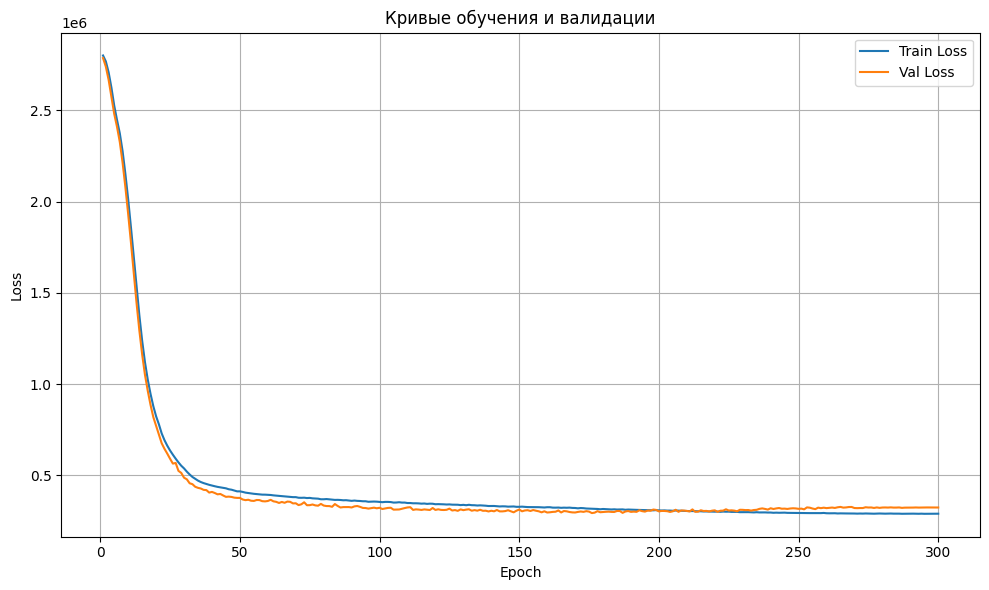

In [6]:
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Кривые обучения и валидации')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Выводы по кривым обучения и валидации

1. **Быстрое снижение в начале**  
   В первые ~30–40 эпох происходит резкий спад как тренировочного, так и валидационного loss — модель сразу захватывает основные закономерности.

2. **Плато и стабилизация**  
   После ~100 эпох кривые практически выровнялись и продолжают очень медленно снижаться, что говорит о приближении к локальному минимуму.

3. **Возможность сокращения числа эпох**  
   Поскольку после ~150-200 эпох улучшения минимальны(даже наоборот начинают проявляться признаки переобучения), можно сократить обучение.

4. **Итоговая ошибка**  
   Окончательный уровень loss ≈ 3 × 10⁵ на обоих наборах и $R^2$≈0.55 на тесте.
